In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sweetviz as sz
from scapy.all import rdpcap
from tueplots import bundles
from tueplots.constants.color import rgb
from matplotlib.colors import LinearSegmentedColormap
import chardet
import binascii



In [5]:
df_all=pd.read_csv(r"C:\\Users\phili\OneDrive - UT Cloud\Data_literacy_mensa\Mensa_data_combined\Friday120124.csv")
df_all

,frame.number,frame.time,wlan.sa,wlan.da,_ws.col.protocol,frame.len,wlan.ssid
0,1,"Jan 12, 2024 10:57:39.977602000 Mitteleuropäis...",NaN,NaN,802.11,2089,NaN
1,2,"Jan 12, 2024 10:57:39.982785000 Mitteleuropäis...",NaN,19:d4:3b:1e:14:44,802.11,751,NaN
2,3,"Jan 12, 2024 10:57:39.986001000 Mitteleuropäis...",5a:ef:5b:d6:c7:3a,2d:2c:93:b7:93:a3,802.11,221,NaN
3,4,"Jan 12, 2024 10:57:39.992557000 Mitteleuropäis...",06:dd:c6:6a:a4:53,NaN,802.11,3665,NaN
4,5,"Jan 12, 2024 10:57:39.994440000 Mitteleuropäis...",8b:53:e0:85:86:9a,ea:1e:89:fe:01:92,802.11,1487,NaN
...,...,...,...,...,...,...,...
2568580,75433,"Jan 12, 2024 14:10:25.579532000 Mitteleuropäis...",NaN,NaN,802.11,47,NaN
2568581,75434,"Jan 12, 2024 14:10:25.602809000 Mitteleuropäis...",00:f6:63:79:03:d0,ff:ff:ff:ff:ff:ff,802.11,303,656475726f616d
2568582,75435,"Jan 12, 2024 14:10:25.603659000 Mitteleuropäis...",NaN,NaN,802.11,382,NaN
2568583,75436,"Jan 12, 2024 14:10:25.604634000 Mitteleuropäis...",NaN,NaN,802.11,2792,NaN


exploring data based on SSID's

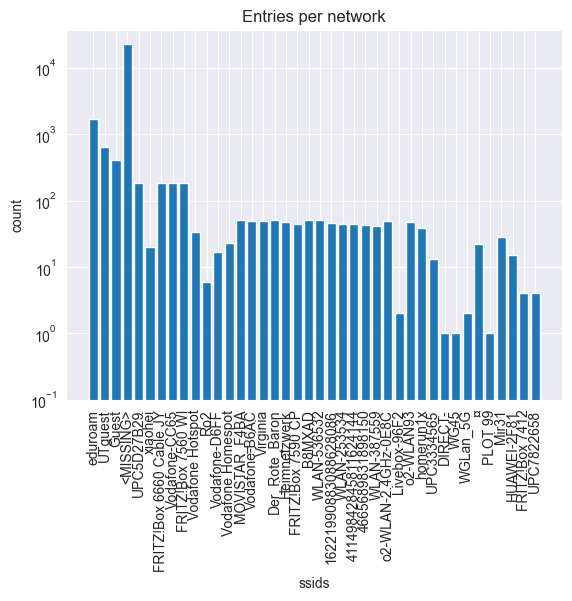

In [6]:
ssids_counts = df_all["wlan.ssid"].value_counts().reset_index()
ssids_counts.columns = ["wlan.ssid", "count"]

# Step 2: Group by WLAN SSID and count the number of unique entries in wlan.sa
unique_sa_counts = df_all.groupby("wlan.ssid")["wlan.sa"].nunique().reset_index()
unique_sa_counts.columns = ["wlan.ssid", "unique_sa_count"]

# Step 3: Merge the two DataFrames on "wlan.ssid"
result = pd.merge(ssids_counts, unique_sa_counts, on="wlan.ssid")
result = result.to_numpy()
# Conversion from hexadecimal to "human"
def hex_to_str(hex_str):
    if len(hex_str) % 2 != 0:
        return hex_str
    bytes_obj = binascii.unhexlify(hex_str)
    return bytes_obj.decode('latin-1')


vec_func = np.vectorize(hex_to_str)

result[:,0] = vec_func(result[:,0])
# This displays the first 40 ssids and their number of entries

names = result[:40, 0]
value = result[:40, 2].astype(int)

plt.bar(names, value)
plt.xlabel("ssids")
plt.xticks(rotation='vertical')
plt.ylabel("count")
plt.yscale("log")
plt.ylim(bottom=0.1)
plt.title("Entries per network")
plt.show()

we get the users on just one SSID network

In [7]:
eduroam_ssid = "656475726f616d"
# The ^ tell the regular expression, that it start with the pattern that follows
cisco_pattern = "^" + "00:f6:63:"

df_dpa = df_all.loc[df_all['_ws.col.protocol'] == "EAP"]

# Authentication with all cisco devices
df_dpa_cisco = df_dpa.loc[df_dpa["wlan.sa"].str.match(cisco_pattern)]

# Authenticated mac addresses as a list
dpa_cisco_list = df_dpa_cisco["wlan.da"].unique().tolist()

# All data filterd for eduroam, UTGuest and Guest
df = df_all.loc[(df_all["wlan.ssid"] == eduroam_ssid)|(df_all["wlan.ssid"] == "55546775657374" )|( df_all["wlan.ssid"] =="4775657374")]

# all unique mac addresses with the ssids
all_sources = df["wlan.sa"].unique().tolist()

# Combination of mac addresses of the ssids and EPA
combined_macs = list(set(all_sources + dpa_cisco_list))
print(f"Number of unqiue mac addresses verfied by cisco: {df_dpa_cisco['wlan.da'].nunique()}")

# All entries that use the resulting mac addresses
df = df_all.loc[df_all['wlan.sa'].isin(combined_macs)]
df = df_all

Number of unqiue mac addresses verfied by cisco: 413


converting the time format to a processable one and dropping all na values in the source set to further clean the data

In [9]:
df["frame.time"] = df["frame.time"].str.replace(r':\d+\.\d+', '', regex=True)
df['frame.time'] = df['frame.time'].str.replace('Mitteleuropäische Zeit', 'CET')
df['date-time'] = pd.to_datetime(df['frame.time'], format='%b %d, %Y %H:%M %Z', errors='coerce')
df['hour:minute'] = df['date-time'].dt.strftime('%H:%M')
df.dropna(subset=["wlan.sa"])

,frame.number,frame.time,wlan.sa,wlan.da,_ws.col.protocol,frame.len,wlan.ssid,date-time,hour:minute
2,3,"Jan 12, 2024 10:57 CET",5a:ef:5b:d6:c7:3a,2d:2c:93:b7:93:a3,802.11,221,NaN,2024-01-12 10:57:00+01:00,10:57
3,4,"Jan 12, 2024 10:57 CET",06:dd:c6:6a:a4:53,NaN,802.11,3665,NaN,2024-01-12 10:57:00+01:00,10:57
4,5,"Jan 12, 2024 10:57 CET",8b:53:e0:85:86:9a,ea:1e:89:fe:01:92,802.11,1487,NaN,2024-01-12 10:57:00+01:00,10:57
9,10,"Jan 12, 2024 10:57 CET",00:f6:63:79:03:d0,ff:ff:ff:ff:ff:ff,802.11,303,656475726f616d,2024-01-12 10:57:00+01:00,10:57
11,12,"Jan 12, 2024 10:57 CET",6d:af:2d:e2:92:08,5d:62:05:b0:ad:3d,802.11,3416,NaN,2024-01-12 10:57:00+01:00,10:57
...,...,...,...,...,...,...,...,...,...
2568570,75423,"Jan 12, 2024 14:10 CET",b8:69:f4:f2:4c:e6,d2:c0:8c:f1:31:bb,QUIC,108,NaN,2024-01-12 14:10:00+01:00,14:10
2568574,75427,"Jan 12, 2024 14:10 CET",b8:69:f4:f2:4c:e6,d2:c0:8c:f1:31:bb,TCP,179,NaN,2024-01-12 14:10:00+01:00,14:10
2568577,75430,"Jan 12, 2024 14:10 CET",00:f6:63:79:03:d1,ff:ff:ff:ff:ff:ff,802.11,253,4775657374,2024-01-12 14:10:00+01:00,14:10
2568579,75432,"Jan 12, 2024 14:10 CET",b8:69:f4:f2:4c:e6,d2:c0:8c:f1:31:bb,TCP,105,NaN,2024-01-12 14:10:00+01:00,14:10


filtering data for mac unique MAC's first and last appreances.

343125
343125


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


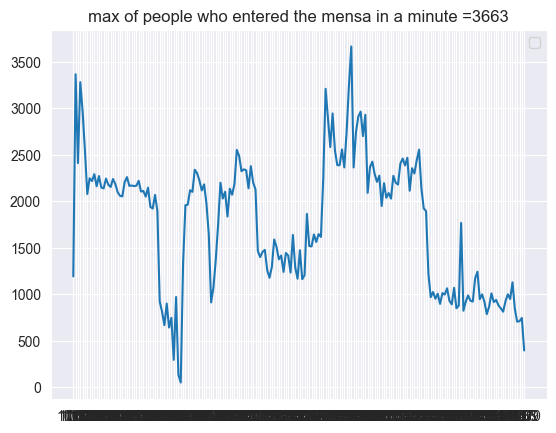

In [10]:
df_first = df.drop_duplicates(subset='wlan.sa', keep='first')
df_last = df.drop_duplicates(subset='wlan.sa', keep='last')
print(df_first["wlan.sa"].nunique())
print(df_last["wlan.sa"].nunique())
f=plt.plot(df_first["hour:minute"].value_counts().sort_index())
max_ent=max(df_first["hour:minute"].value_counts().sort_index())
plt.title("max of people who entered the mensa in a minute ={x}".format(x=max_ent))
plt.legend()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


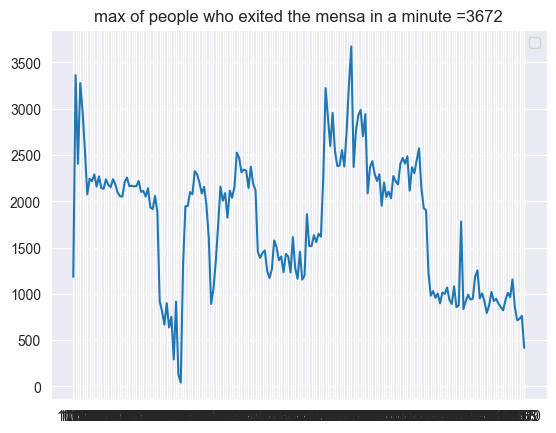

In [11]:
max_ext=max(df_last["hour:minute"].value_counts().sort_index())
l=plt.plot(df_last["hour:minute"].value_counts().sort_index())
plt.title("max of people who exited the mensa in a minute ={x}".format(x=max_ext))
plt.legend()

we check how many mac addresses were seen for the first and the last time in the network per minute.

Text(0.5, 1.0, 'New MAC id seen in the network Count/ minute')

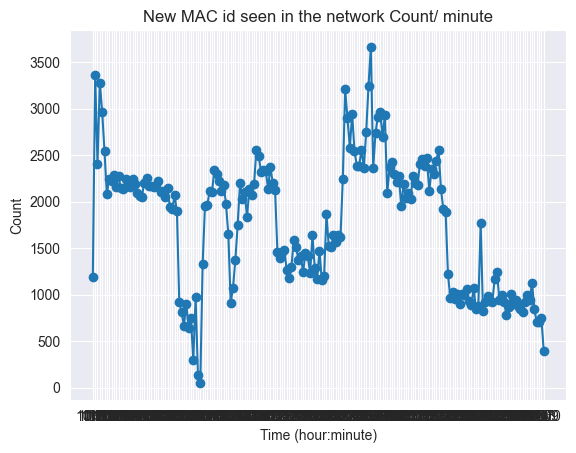

In [12]:
per_min_new=pd.DataFrame(df_first["hour:minute"].value_counts().sort_index())
plt.plot(per_min_new['count'], marker='o')
plt.xlabel('Time (hour:minute)')
plt.ylabel('Count')
plt.title('New MAC id seen in the network Count/ minute')

Text(0.5, 1.0, 'last seen unique MAC id seen in the network Count/ minute')

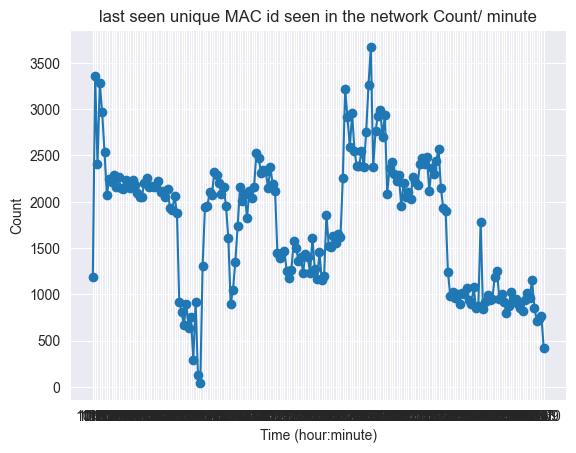

In [13]:
per_min_last=pd.DataFrame(df_last["hour:minute"].value_counts().sort_index())
plt.plot(per_min_last['count'], marker='o')
plt.xlabel('Time (hour:minute)')
plt.ylabel('Count')
plt.title('last seen unique MAC id seen in the network Count/ minute')

how many mac addresses were seen for the first and the last time in the network at 5 min time intervals

Text(0.5, 1.0, 'first seen Count / 5 min')

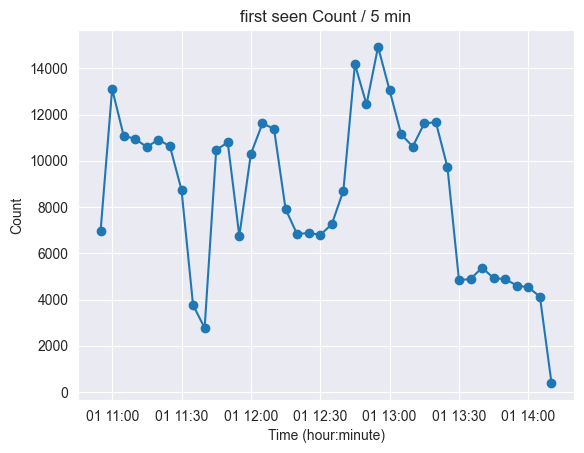

In [14]:
_5min_new = pd.DataFrame({'hour:minute':per_min_new.index.tolist(),'count': per_min_new["count"]})
_5min_new['hour:minute'] = pd.to_datetime(_5min_new['hour:minute'], format='%H:%M')
_5min_new['hour:minute'].dt.strftime('%H:%M')
_5min_new.set_index('hour:minute',inplace=True)
_5min_new_ = _5min_new.resample('5T').sum()
#_5min_new_
plt.plot(_5min_new_['count'], marker='o')
plt.xlabel('Time (hour:minute)')
plt.ylabel('Count')
plt.title('first seen Count / 5 min')

Text(0.5, 1.0, 'last seen Count / 5 min')

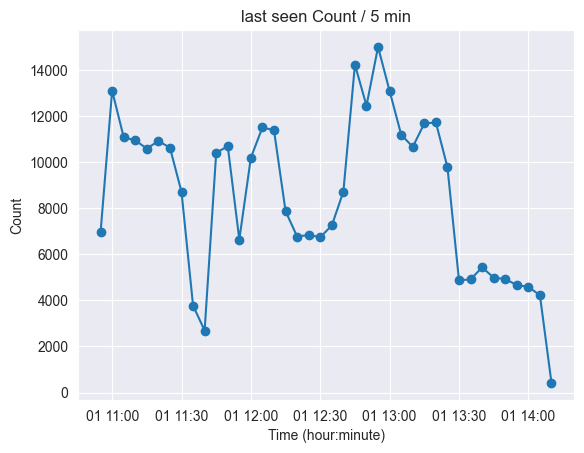

In [15]:
_5min_last = pd.DataFrame({'hour:minute':per_min_last.index.tolist(),'count': per_min_last["count"]})
_5min_last['hour:minute'] = pd.to_datetime(_5min_last['hour:minute'], format="%H:%M")
_5min_last.set_index('hour:minute', inplace=True)
last_per5min_ = _5min_last.resample('5T').sum()
#last_per5min_
plt.plot(last_per5min_['count'], marker='o')
plt.xlabel('Time (hour:minute)')
plt.ylabel('Count')
plt.title('last seen Count / 5 min')

total number of users seen during a day based on MAC id's number of people present in the mensa at a particular time

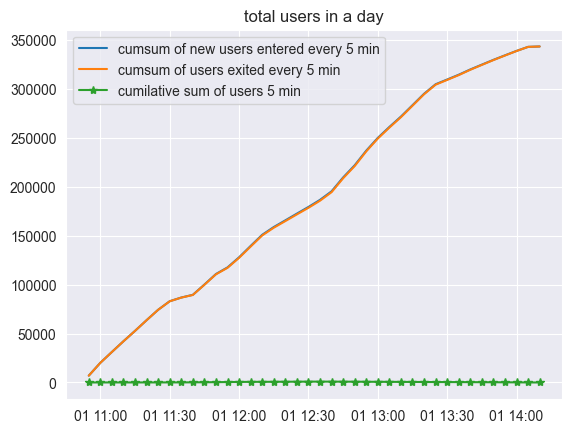

In [16]:
np.cumsum(_5min_new_['count'])
plt.plot(np.cumsum(_5min_new_['count']),label="cumsum of new users entered every 5 min")
plt.plot(np.cumsum(last_per5min_['count']),label="cumsum of users exited every 5 min")
plt.plot(np.cumsum(_5min_new_['count'])-np.cumsum(last_per5min_['count']), marker='*',label="cumilative sum of users 5 min")
plt.title("total users in a day")
plt.legend()

lookinng at the difference in order to estimate the que forming due to the entering of new people in the network

In [17]:
cu=(np.cumsum(_5min_new_['count'])-np.cumsum(last_per5min_['count']))
cu.max()


870

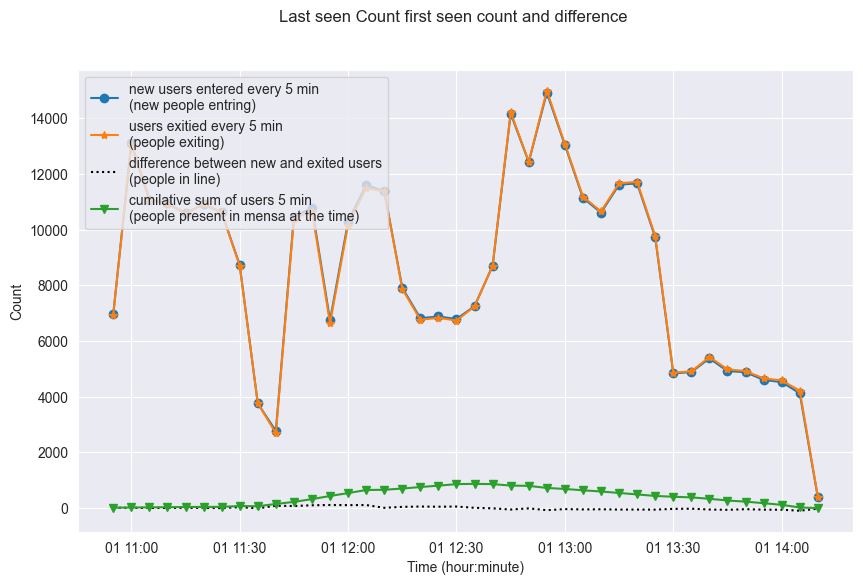

In [18]:
plt.figure(figsize=(10,6))
plt.plot(_5min_new_['count'], marker='o',label="new users entered every 5 min\n(new people entring)")
plt.plot(last_per5min_['count'], marker='*',label="users exitied every 5 min\n(people exiting)")
plt.plot((_5min_new_['count']-last_per5min_['count']),color="black", linestyle=":",label="difference between new and exited users\n(people in line)")
plt.plot(((np.cumsum(_5min_new_['count'])-np.cumsum(last_per5min_['count']))), marker='v',label="cumilative sum of users 5 min\n(people present in mensa at the time)")
plt.xlabel('Time (hour:minute)')
plt.ylabel('Count')
plt.suptitle('Last seen Count first seen count and difference')
#plt.title("(the value of orange and blue lines are divided by 10 to make it comparable to difference)", fontsize="small")
plt.legend(loc="upper left")

In [19]:
df_first = df_first.dropna(subset=["wlan.sa"])

difference between first and last seen time

In [20]:
from tqdm import tqdm
# df_first["hour:minute"] = pd.to_datetime(df_first["hour:minute"])
# df_last["hour:minute"] = pd.to_datetime(df_last["hour:minute"])
diff=[]

grouped_first_source = df_first.groupby("wlan.sa")
grouped_last_source = df_last.groupby("wlan.sa")

for name, group in tqdm(grouped_first_source, total=len(grouped_first_source)):
    index_first = group["hour:minute"].tolist()[0]
    first_hour, first_minute = map(int, index_first.split(':'))
    first_time = first_hour * 60 + first_minute

    try:
        index_last_source = grouped_last_source.get_group(name)["hour:minute"].tolist()[0]
        last_hour_source, last_minute_source = map(int, index_last_source.split(':'))
        last_time_source = last_hour_source * 60 + last_minute_source
    except KeyError:
        continue
        
    # Calculate the time difference between corresponding rows in minutes
    time_diff = (last_time_source - first_time)
    # # Append the wlan.sa value and time difference in minutes to the result list
    diff.append({"wlan.sa": name, "time_difference": time_diff})
    
# for name, group in tqdm(grouped_first_source, total=len(grouped_first_source)):
#     index_first = group["hour:minute"].tolist()[0]
#     first_hour, first_minute = map(int, index_first.split(':'))
#     first_time = first_hour * 60 + first_minute
# 
#     try:
#         index_last_source = grouped_last_source.get_group(name)["hour:minute"].tolist()[0]
#         last_hour_source, last_minute_source = map(int, index_last_source.split(':'))
#         last_time_source = last_hour_source * 60 + last_minute_source
#     except KeyError:
#         continue
#         
#     # Calculate the time difference between corresponding rows in minutes
#     time_diff = (last_time_source - first_time)
#     # # Append the wlan.sa value and time difference in minutes to the result list
#     diff.append({"wlan.sa": name, "time_difference": time_diff})
        
diff_df=pd.DataFrame(diff)
diff_df.drop_duplicates(subset='wlan.sa', keep='first')
#print(time_diff.sort_index())


100%|██████████| 343125/343125 [01:07<00:00, 5116.93it/s]


,wlan.sa,time_difference
0,00:00:00:00:00:00,193
1,00:00:00:00:00:80,87
2,00:00:00:00:00:98,0
3,00:00:00:00:11:46,0
4,00:00:00:00:40:25,0
...,...,...
343120,ff:ff:d4:61:f0:fb,0
343121,ff:ff:ff:7f:d6:3a,0
343122,ff:ff:ff:bf:db:ff,0
343123,ff:ff:ff:ff:ff:5f,0


In [21]:
time_d=diff_df["time_difference"].value_counts().sort_index()
print((diff_df.loc[diff_df['time_difference']!=0]).count())

wlan.sa            1973
time_difference    1973
dtype: int64


see how long a person stays in the mensa network

below is the histogram along with the violinplot showing how the average time spent at mensa is distributed

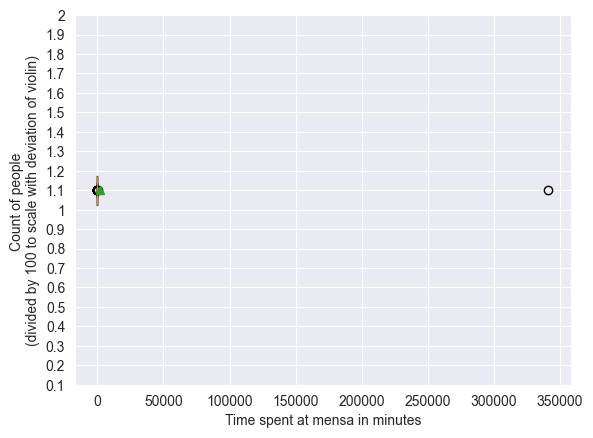

In [25]:
#plt.hist(time_d.index, weights=time_d, bins=180, alpha=0.7)
plt.boxplot(time_d.sort_index(), vert=False, showmeans=True)
plt.xlabel("Time spent at mensa in minutes")
plt.ylabel("Count of people \n(divided by 100 to scale with deviation of violin)")
plt.yticks(np.arange(0,2 , step=.1),labels=(0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2))
plt.show()

In [23]:
'''    diff_df["time_difference"].sort_values( ascending=False)
    diff_df.drop_duplicates(subset='wlan.sa', keep='first')
    fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True,)
    ax1.hist(time_diff.index, weights=time_diff, bins=20)
    ax2.violinplot(time_diff.index, showmeans=True)
    fig.text(0.5, 0.04, 'X-axis Label', ha='center')
    fig.text(0.04, 0.5, 'Y-axis Label', va='center', rotation='vertical')
    fig.subplots_adjust(wspace=0, hspace=0)

    plt.show()'''

'    diff_df["time_difference"].sort_values( ascending=False)\n    diff_df.drop_duplicates(subset=\'wlan.sa\', keep=\'first\')\n    fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True,)\n    ax1.hist(time_diff.index, weights=time_diff, bins=20)\n    ax2.violinplot(time_diff.index, showmeans=True)\n    fig.text(0.5, 0.04, \'X-axis Label\', ha=\'center\')\n    fig.text(0.04, 0.5, \'Y-axis Label\', va=\'center\', rotation=\'vertical\')\n    fig.subplots_adjust(wspace=0, hspace=0)\n\n    plt.show()'